#### Group Information

Group No: 

- Member 1: Lai Yicheng
- Member 2: Lee Ying Shen
- Member 3: Lim Ting Juin
- Member 4: Koay Chun Keat

#### Import Libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
print("TensorFlow version:", tf.__version__)

# Set a random seed for reproducible results 
tf.random.set_seed(42)

TensorFlow version: 2.16.1


#### Load the dataset

In [15]:
ds = pd.read_csv('classification_dataset.csv')
ds.head()

,f1,f2,f3,f4,f5,label
0,1.286233,15.643743,-1.879915,-11.294839,15.245472,0
1,2.853398,0.129878,17.620669,3.945204,8.157459,1
2,3.285310,3.176560,12.610554,-6.063613,1.831887,0
3,2.019516,-1.967793,9.306435,-0.938714,-1.203038,0
4,-2.326527,3.453234,13.855478,-5.236421,1.547216,0


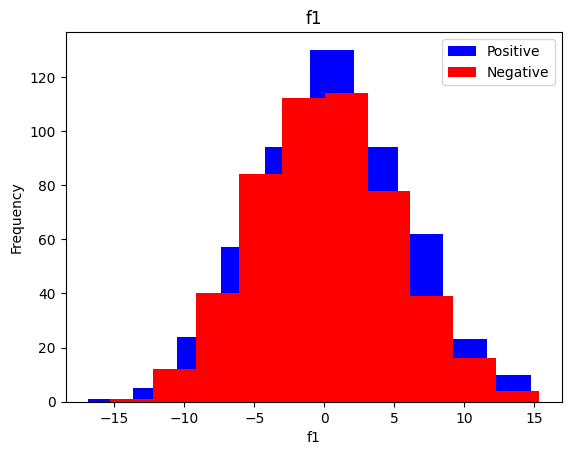

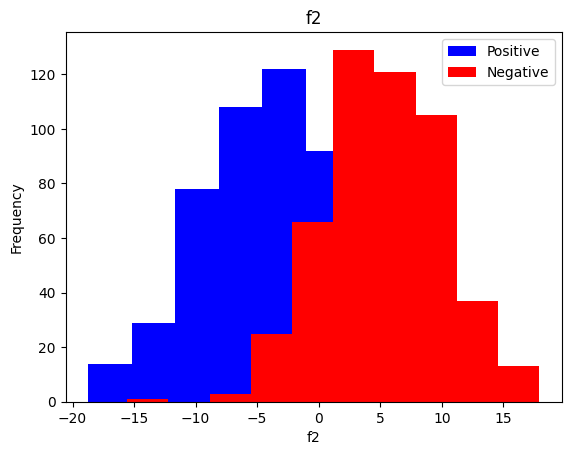

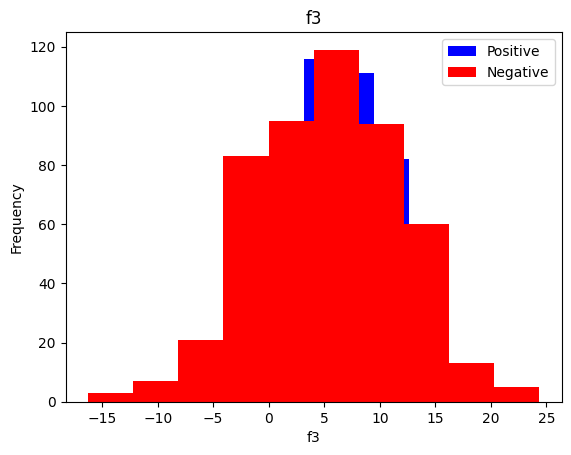

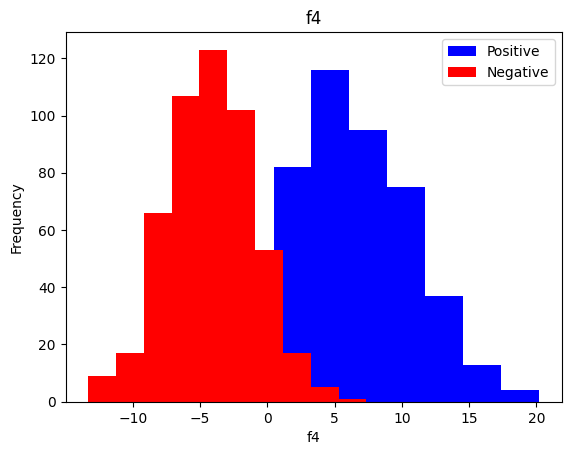

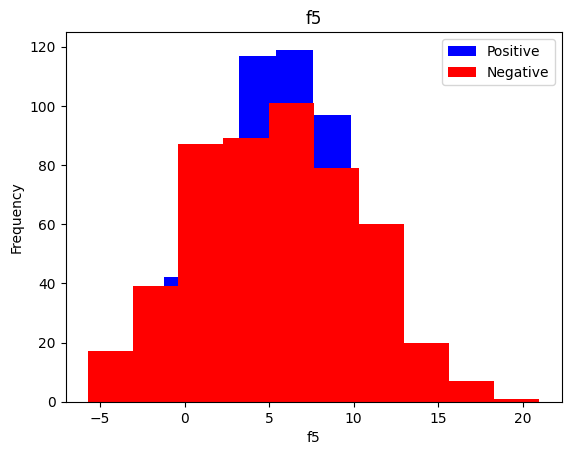

In [4]:
for i in range(len(ds.columns[:-1])):
  label = ds.columns[i]
  plt.hist(ds[ds['label'] == 1][label], color="blue", label="Positive")
  plt.hist(ds[ds['label'] == 0][label], color="red", label="Negative")
  plt.title(label)
  plt.ylabel("Frequency")
  plt.xlabel(label)
  plt.legend()
  plt.show()

#### Define the loss function

In [5]:
def loss_fn(y_true, y_pred):
    """
    This function calculates the loss function
    """
    # return 0.5 * tf.reduce_mean(tf.square(y_true - y_pred)) # equivalent to formula (1/2m) * sum((y_true - y_predict)^2)
    # add epsilon to prevent log(0)
    epsilon = 1e-7
    return -tf.reduce_mean(y_true * tf.math.log(y_pred + epsilon) + (1 - y_true) * tf.math.log(1 - y_pred + epsilon))


#### Define function to perform prediction

In [6]:
def sigmoid(weighted_sum):
    """

    This function calculates the sigmoid function.

    Parameters: weighted_sum (float): The weighted sum of inputs.

    Returns: result (float): The result of the sigmoid function.
    
    """

    result = 1 / (1 + tf.exp(-weighted_sum))
    return result


def relu(weighted_sum):
    """

    This function calculates the ReLU function.

    Parameters: weighted_sum (float): The weighted sum of the inputs and weights.

    Returns: result (float): The result of the ReLU function.

    """

    return tf.maximum(0.0, weighted_sum)


# feedforward neural network (FNN)
def forward(inputs, weights, biases):
    """

    This function calculates the forward pass (predicts the label).

    Parameters: inputs (list): The input features, weights (list): The weights of the neural network.

    Returns: prediction (float): The predicted label.
    
    """

    weighted_sum_input = tf.matmul(inputs, weights["w_hidden"], False, True) + biases["b_hidden"]
    # print("weightedsuminput: ", weighted_sum_input)
    output_hidden_activation = relu(weighted_sum_input)
    # print("hiddenactivation: ", output_hidden_activation)

    weighted_sum_activation = tf.matmul(output_hidden_activation, weights["w_output"], False, True) + biases["b_output"]
    # print("weightedsumactivation: ", weighted_sum_activation)
    prediction = sigmoid(weighted_sum_activation)
    # print("prediction:", prediction)

    return prediction

#### Define function for model training
Display the training and validation loss values for each epoch of the training loop. The displayed value must be in 6 decimal places.<br>
Hint: <br>
Use `tf.GradientTape` to compute the gradients.

In [7]:
def train(x_train, y_train, weights, biases, learning_rate):
    """

    This function performs the forward pass, computes the gradient and update the weights and biases.

    Parameters: x_train (list): The input features, y_true (float): The true label, weights (list): The weights of the neural network, biases (list): The biases of the neural network, learning_rate (float): The learning rate.

    Returns: weights (list): The updated weights, biases (list): The updated biases, loss (float): The loss value.

    """

    with tf.GradientTape() as t:
        # Perform the forward pass
        y_pred = forward(x_train, weights, biases)

        # Compute the loss
        loss = loss_fn(y_train, y_pred)

    # Perform the backward pass/ backprop

    # 1. Compute the gradients
    gradients = t.gradient(
        loss,
        [
            weights["w_hidden"],
            biases["b_hidden"],
            weights["w_output"],
            biases["b_output"],
        ],
    )

    # 2. Update weights and biases
    weights["w_hidden"].assign_sub(learning_rate * gradients[0])
    biases["b_hidden"].assign_sub(learning_rate * gradients[1])
    weights["w_output"].assign_sub(learning_rate * gradients[2])
    biases["b_output"].assign_sub(learning_rate * gradients[3])
    # print("gradients: ", gradients)

    return weights, biases, loss


def fit(x_train, y_train, x_valid, y_valid, weights, biases, learning_rate, epochs=10, batches=32):
    """

    This function implements the training loop.

    Parameters: x_train (list): The input features for training, y_train (list): The true labels for training, x_valid (list): The input features for validation, y_valid (list): The true labels for validation, weights (list): The weights of the neural network, biases (list): The biases of the neural network, learning_rate (float): The learning rate, epochs (int): The number of epochs, batches (int): The number of batches.

    Returns: train_losses (list): The training losses, valid_losses (list): The validation losses.

    """

    train_losses = []
    valid_losses = []

    for i in range(epochs):
        # Mini-batch gradient descent implementation for training
        for j in range(0, len(x_train), batches):
            x_train_batch = x_train[j : j + batches]
            y_train_batch = y_train[j : j + batches]
            weights, biases, loss = train(
                x_train_batch, y_train_batch, weights, biases, learning_rate
            )
        train_losses.append(loss)

        # Evaluate validation loss after each epoch to detect overfitting
        _, _, valid_loss = train(x_valid, y_valid, weights, biases, learning_rate)
        valid_losses.append(valid_loss)

        # print("train_losses", train_losses)
        # print("valid_losses", valid_losses)
        
        # format the loss to 6 decimal places
        formatted_train_loss = f"{train_losses[-1]:.6f}"
        formatted_valid_loss = f"{valid_losses[-1]:.6f}"
        print(
            f"Epoch: {i}, Train Loss: {formatted_train_loss}, Validation Loss: {formatted_valid_loss}"
        )

    return train_losses, valid_losses

#### Define the tensors to hold the weights and biases (create the model)
Hint: <br>
Use `tf.Variable` to create the tensors.<br>
Put the tensors in a list.

In [8]:
ds_tf = tf.Variable(ds)
ds_tf

# Example weights (randomly initialized)
np.random.seed(42)

weights = {
  "w_hidden": tf.Variable(np.random.randn(5, 5)),  # Weight matrix for hidden layer
  "w_output": tf.Variable(np.random.randn(1, 5)),  # Weight matrix for output layer
}

biases = {
  "b_hidden": tf.Variable(np.random.randn(1,5)),  # Bias vector for hidden layer
  "b_output": tf.Variable(np.random.randn(1)),  # Bias vector for output layer
}

learning_rate = tf.constant(0.01, dtype=tf.float64)

#### Split the dataset
The ratio of training and test is 7:1:2.

In [9]:
ds_shuffle = tf.random.shuffle(ds_tf, seed=42) # shuffle the dataset
train_size = int(0.7 * len(ds))
valid_size = int(0.1 * len(ds))
test_size = int(0.2 * len(ds))
train_data, valid_data, test_data = ds_shuffle[:train_size], ds_shuffle[train_size:train_size + valid_size], ds_shuffle[train_size + valid_size:]

x_train, y_train = train_data[:, :-1], train_data[:, -1]
x_valid, y_valid = valid_data[:, :-1], valid_data[:, -1]
x_test, y_test = test_data[:, :-1], test_data[:, -1]

#### Normalize the data

In [10]:
norm_x_train = (x_train - tf.reduce_mean(x_train, axis=0)) / tf.math.reduce_std(x_train, axis=0)
norm_x_valid = (x_valid - tf.reduce_mean(x_valid, axis=0)) / tf.math.reduce_std(x_valid, axis=0)
norm_x_test = (x_test - tf.reduce_mean(x_test, axis=0)) / tf.math.reduce_std(x_test, axis=0)

#### Train the model

In [11]:
# Train the model
train_losses, valid_losses = fit(norm_x_train, y_train, norm_x_valid, y_valid, weights, biases, learning_rate, 30)

Epoch: 0, Train Loss: 1.416180, Validation Loss: 1.644483
Epoch: 1, Train Loss: 1.093008, Validation Loss: 1.292152
Epoch: 2, Train Loss: 0.900471, Validation Loss: 1.059216
Epoch: 3, Train Loss: 0.810347, Validation Loss: 0.924569
Epoch: 4, Train Loss: 0.772823, Validation Loss: 0.849889
Epoch: 5, Train Loss: 0.756466, Validation Loss: 0.807253
Epoch: 6, Train Loss: 0.747639, Validation Loss: 0.781394
Epoch: 7, Train Loss: 0.741411, Validation Loss: 0.764641
Epoch: 8, Train Loss: 0.736277, Validation Loss: 0.753143
Epoch: 9, Train Loss: 0.731839, Validation Loss: 0.744894
Epoch: 10, Train Loss: 0.728014, Validation Loss: 0.738782
Epoch: 11, Train Loss: 0.724771, Validation Loss: 0.734144
Epoch: 12, Train Loss: 0.722060, Validation Loss: 0.730554
Epoch: 13, Train Loss: 0.719809, Validation Loss: 0.727723
Epoch: 14, Train Loss: 0.717943, Validation Loss: 0.725451
Epoch: 15, Train Loss: 0.716384, Validation Loss: 0.723593
Epoch: 16, Train Loss: 0.715056, Validation Loss: 0.722046
Epoch: 

#### Display the training loss and validation loss against epoch graph

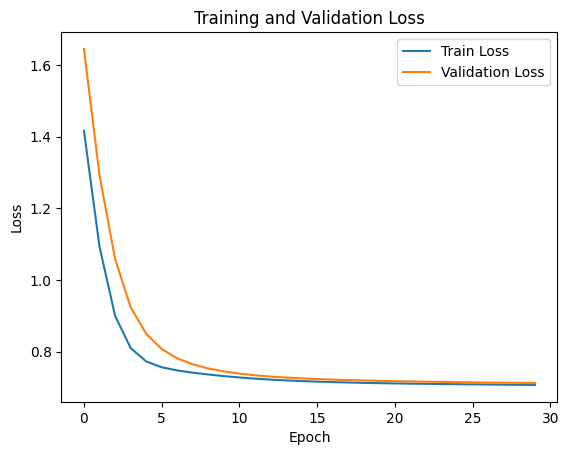

In [12]:
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Predict the test set

In [13]:
# predict test set
y_pred = forward(norm_x_test, weights, biases)

#### Display the confusion matrix and the classification report.

In [14]:
y_pred = tf.where(y_pred > 0.5, 1, 0)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[55 46]
 [75 24]]
              precision    recall  f1-score   support

         0.0       0.42      0.54      0.48       101
         1.0       0.34      0.24      0.28        99

    accuracy                           0.40       200
   macro avg       0.38      0.39      0.38       200
weighted avg       0.38      0.40      0.38       200

